In [1]:
import pandas as pd
import sys
import random
import time
import numpy as np
import pandas.compat as ct
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
#reading_data
train_data=pd.read_csv('bio_train.dat',header=None,delimiter='\t')

In [3]:
#columns(Sequence_Id,Example_Id,Homologous,Features...)
train_data.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76],
           dtype='int64')

In [4]:
#calculation of mean for lightweight coreset
st=time.time()
mean=train_data.iloc[:,3:].mean()


In [5]:
#calculation of q for lightweight coreset
distances=np.sum((train_data.iloc[:,3:]-mean)**2,axis=1)
distances=distances/np.sum(distances,axis=0)
prob= 0.5* 1/len(train_data) + 0.5 * distances
add=time.time()-st

In [8]:
#function to get coreset of size m using lightweight coreset
def getcoreset(m):
    indices=np.random.choice(range(len(train_data)),m,replace=True,p=prob)
    prob_coreset=1/(m*prob[indices])
    coreset=pd.DataFrame(train_data.iloc[indices,3:],index=indices)
    return np.array(coreset),np.array(prob_coreset).reshape(1,m)
    
    

In [9]:
#function to get coreset of size m using protras algorithm
def farthestfirst(m):
    centers=[]
    distances=[]
    centers.append(random.randint(0,len(train_data)))
    min_val=np.full((len(train_data),1),np.inf)
    cur=0
    while(len(centers)<m):
        if cur==0:
            distances=np.linalg.norm(train_data.iloc[:,3:]-train_data.iloc[centers[cur],3:],axis=1,keepdims=True)
        else:
            d_latest=np.linalg.norm(train_data.iloc[:,3:]-train_data.iloc[centers[cur],3:],axis=1,keepdims=True)
            distances=np.concatenate((distances,d_latest),axis=1)
        arg_mins=np.argmin(distances,axis=1)
        #print(arg_mins)
        max_wd=0
        pt=-1
        for i in range(cur+1):
            indices=np.where(arg_mins==i)[0]
            p=np.max(distances[indices,i])
            max_val=p*len(indices)
            if max_wd<max_val:
                max_wd=p
                pt=indices[np.argmax(distances[indices,i])]
        centers.append(pt)    
        cur+=1
    return np.array(train_data.iloc[centers,3:])
        
        

In [10]:
#function to calculate quantization error
def objective_function(df,centers,weights):
    min_val=np.full((len(df),1),np.inf)
    for j in centers:
        ar=np.linalg.norm(df-j,axis=1,keepdims=True)
        np.amin(np.concatenate((min_val,ar),axis=1),axis=1,keepdims=True,out=min_val)
    #print(min_val.shape,weights.shape)
    return np.matmul(weights,min_val).ravel()[0]


In [11]:
# function to perform experiments on lightweight coreset with coreset size=m
def evaluate_coreset(m,centers=50):
    start=time.time()
    coreset,weights=getcoreset(m)
    end=time.time()-start+add
    res=KMeans(n_clusters=centers,n_init=50).fit(coreset)
    loss=objective_function(coreset,res.cluster_centers_,weights)
    print("loss for ",m," samples for lightweight coreset = ",loss)
    print("total time taken is",time.time()-start)
    return loss,end
    

In [12]:
# function to perform experiments on ProTras with coreset size=m
def evaluate_fft(m,centers=50):
    start=time.time()
    coreset=farthestfirst(m)
    end=time.time()-start
    res=KMeans(n_clusters=centers,n_init=50).fit(coreset)
    loss=objective_function(coreset,res.cluster_centers_,np.ones((1,m)))
    print("loss for ",m," samples for farthest first = ",loss)
    print("total time taken is",time.time()-start)
    return loss,end

In [13]:
# function to perform experiments on Uniform subsampling with coreset size=m
def evaluate_uniform(m,centers=50):
    start=time.time()
    indices=np.random.choice(range(len(train_data)),m,replace=True)
    coreset=train_data.iloc[indices,3:]
    end=time.time()-start
    res=KMeans(n_clusters=centers,n_init=50).fit(coreset)
    loss=objective_function(coreset,res.cluster_centers_,np.ones((1,m)))
    print("loss for ",m," samples for uniform sampling = ",loss)
    print("total time taken is",time.time()-start)
    return loss,end

In [60]:
# calculation of quantization error on full dataset
start=time.time()
res=KMeans(n_clusters=50).fit(train_data.iloc[:,3:])
loss_full=objective_function(np.array(train_data.iloc[:,3:]),res.cluster_centers_,np.ones((1,len(train_data))))
print("loss for full dataset is ",loss_full)
print("total time taken is",time.time()-start)

loss for full dataset is  151899183.56066716
total time taken is 390.54020071029663


In [28]:
#experiments on lightweight coreset
uniform_time=[]
uniform_loss=[]
fft_loss,fft_time=[],[]
lcoreset_loss,lcoreset_time=[],[]
for i in [100,200,500,1000]:
    loss,tme=evaluate_coreset(i)
    lcoreset_time.append(tme)
    lcoreset_loss.append(loss)
a=[]
a.append('Sequence_id')
a.append('Example_id')
a.append('Homologous')
for i in range(74):
    a.append('feature_'+str(i))
train_data.columns=a
    


loss for  100  samples for lightweight coreset =  94487776.65924554
total time taken is 1.5237984657287598
loss for  200  samples for lightweight coreset =  143814420.42101818
total time taken is 2.7878246307373047
loss for  500  samples for lightweight coreset =  161668327.1157684
total time taken is 3.951779842376709
loss for  1000  samples for lightweight coreset =  160162528.9244365
total time taken is 6.203278064727783


In [64]:
#experiments on uniform subsampling
for i in [100,200,500,1000]:    
    loss,tme=evaluate_uniform(i)
    uniform_time.append(tme)
    uniform_loss.append(loss)

loss for  100  samples for uniform sampling =  41004.98503418902
total time taken is 2.144543409347534
loss for  200  samples for uniform sampling =  138700.39966072934
total time taken is 3.3499221801757812
loss for  500  samples for uniform sampling =  457818.961370684
total time taken is 4.166352033615112
loss for  1000  samples for uniform sampling =  971755.5195884288
total time taken is 5.704540014266968


In [65]:
#experiments on ProTras
for i in [100,200,500,1000]:
    loss,tme=evaluate_fft(i)
    fft_time.append(tme)
    fft_loss.append(loss)



loss for  100  samples for farthest first =  118513.1092884527
total time taken is 20.088097095489502
loss for  200  samples for farthest first =  441109.21497638564
total time taken is 67.85809373855591
loss for  500  samples for farthest first =  1130916.5823197986
total time taken is 187.47746062278748
loss for  1000  samples for farthest first =  2226736.717673872
total time taken is 486.2215631008148


In [66]:
#calculation of relative error
loss1,loss2,loss3=[],[],[]
for i in range(4):
    loss1.append(abs(uniform_loss[i]-loss_full)/loss_full)
    loss2.append(abs(lcoreset_loss[i]-loss_full)/loss_full)
    loss3.append(abs(fft_loss[i]-loss_full)/loss_full)

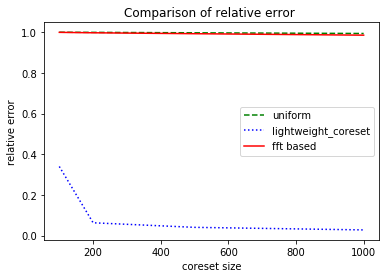

In [69]:
#generate plot of coreset size vs relative error
plt.plot([100,200,500,1000],loss1,color='green',linestyle='dashed',label='uniform_sampling')
plt.plot([100,200,500,1000],loss2,color='blue',linestyle=':',label='coreset_sampling')
plt.plot([100,200,500,1000],loss3,color='red',linestyle='-',label='fft based sampling')
plt.xlabel('coreset size')
plt.ylabel('relative error')
plt.legend(['uniform','lightweight_coreset','fft based'])
plt.title('Comparison of relative error ')
plt.savefig('comp.png')

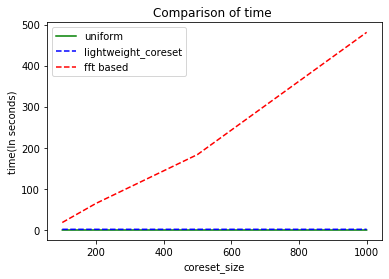

In [70]:
#generate plot of coreset size vs time
plt.plot([100,200,500,1000],uniform_time,color='green',linestyle='-')
plt.plot([100,200,500,1000],lcoreset_time,color='blue',linestyle='--')
plt.plot([100,200,500,1000],fft_time,color='red',linestyle='--')
plt.xlabel('coreset_size')
plt.ylabel('time(In seconds)')
plt.legend(['uniform','lightweight_coreset','fft based'])
plt.title('Comparison of time ')
plt.savefig('time.png')